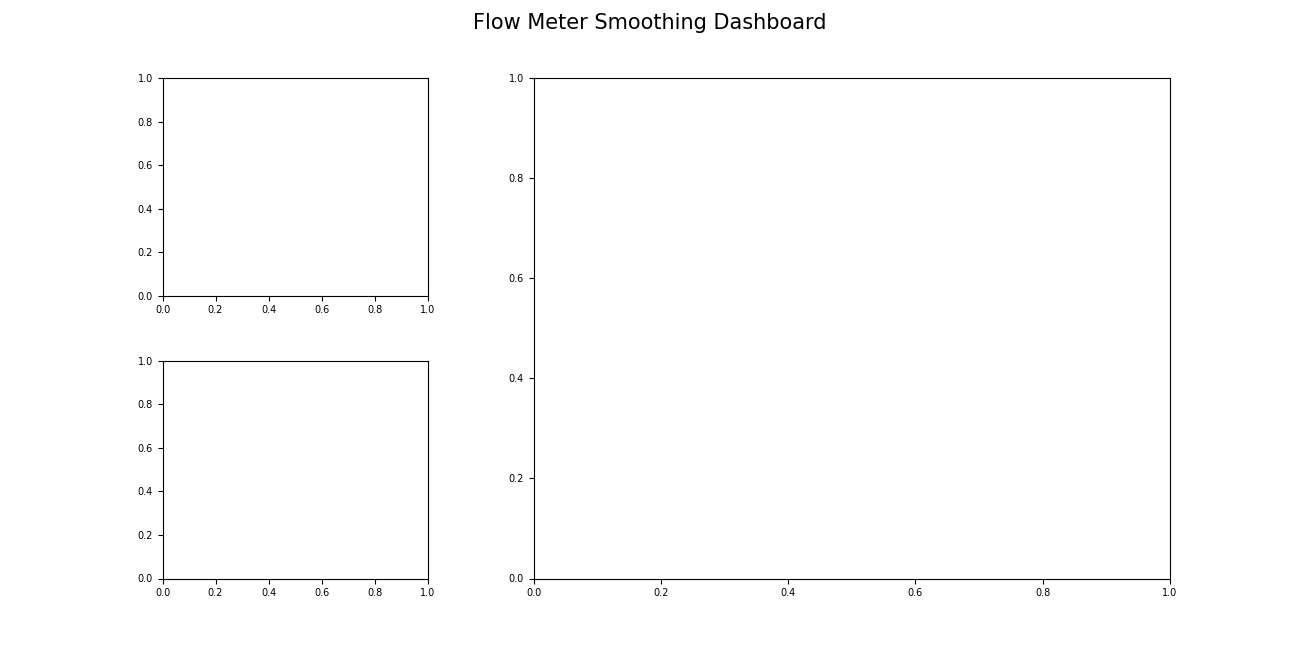

In [1]:
%matplotlib ipympl
#%matplotlib inline

import pandas as pd
import random
import ipywidgets, asyncio, time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from AlicatMFC import ewm
import AlicatMFC as alicat
itemLayout = ipywidgets.Layout(width = "auto",height = "30px")
def colLayout(wid):
    return ipywidgets.Layout(display = "flex",flex_flow='column',border = '1px solid black',align_items = "stretch",justify_content="flex-start",width = wid)

totalTime = ipywidgets.Textarea(description="time", layout = itemLayout)
elapsedTime = ipywidgets.Textarea(description="interval" ,layout = itemLayout)
currentData = ipywidgets.Textarea(description="data" ,layout = itemLayout)

running = ipywidgets.ToggleButton(description="start", icon="play",button_style = 'danger', layout = itemLayout)
interval = ipywidgets.FloatSlider(description="loop interval", value=1, min=0.001, max=2,step = 0.001, layout = itemLayout) # zero can hang if you don't await
xlim = ipywidgets.IntSlider(description="xlim", value=50, min=10, max=1000, layout = itemLayout)
ewmNum = ipywidgets.IntText(description="EWM COM",value = 15 ,layout = itemLayout)
recentNum = ipywidgets.IntText(description = "recency",value = 20 ,layout = itemLayout)

volFlow = ipywidgets.FloatText(description = 'Vol Flow')
massFlow = ipywidgets.FloatText(description = "Mass Flow")
volEWM = ipywidgets.FloatText(description = 'Vol EWM')
volMean = ipywidgets.FloatText(description = 'Vol Mean')
recMin = ipywidgets.FloatText(description = 'Recent Min')
recMax = ipywidgets.FloatText(description = 'Recent Max')
Min = ipywidgets.FloatText(description = 'Vol Min')
Max = ipywidgets.FloatText(description = 'Vol Max')
           
row1 = ipywidgets.HBox([volFlow, massFlow])
row2 = ipywidgets.HBox([volMean,volEWM])
row3 = ipywidgets.HBox([recMax,recMin])
row4 = ipywidgets.HBox([Max,Min])
table = ipywidgets.VBox([row1,row2,row3,row4])


col1 = ipywidgets.VBox(children = [running,ewmNum,recentNum,xlim])
col2 = ipywidgets.VBox(children = [totalTime,elapsedTime,currentData,interval])
ui = ipywidgets.HBox([col1,col2,table])

tasks = dict()

dfFlow = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','volumetric_flow ewm','mass_flow ewm'])       

times = [time.time()]
startTime = time.time()

async def do_work(t):
    flowDict = alicat.getFlowData()
    flowData = [[flowDict.get("pressure"),flowDict.get("temperature"),flowDict.get("volumetric_flow"),flowDict.get("mass_flow"),0,0]]
    dfNew = pd.DataFrame(flowData, columns = ['pressure','temperature','volumetric_flow','mass_flow','volumetric_flow ewm','mass_flow ewm'])
    global dfFlow
    dfFlow = pd.concat([dfFlow,dfNew],ignore_index = True)
    currentData.value = ', '.join(str(val) for val in flowData[0])
    
    # #calculate and add ewm  
    dfFlow["volumetric_flow ewm"] = dfFlow["volumetric_flow"].ewm(com = ewmNum.value).mean()
    dfFlow["mass_flow ewm"] = dfFlow["mass_flow"].ewm(com = ewmNum.value).mean()
    
    for ax in axes:
        axes[ax].clear()
        axes[ax].set_xlim([dfFlow.shape[0]-xlim.value, dfFlow.shape[0]])
    
    #update each plot
    axes["C"].set_title("Volumetric Flow")
    axes["C"].plot(dfFlow["volumetric_flow"].to_numpy(), label = "Volumetric Flow Rate (mLPM)", color = "black")
    axes["C"].plot(dfFlow["volumetric_flow ewm"].to_numpy(), label = "Vol Flow Smoothed (mLPM)", color = "cyan")
    #axes["C"].set_ylim(dfFlow.tail(xlim.value)["volumetric_flow"].min(),dfFlow.tail(xlim.value)["volumetric_flow"].max())
    
    axes["A"].set_title("Temp/Pressure")
    axes["A"].plot(dfFlow["pressure"].to_numpy(), label = "Pressure (PSIA)", color = "green")
    axes["A"].plot(dfFlow["temperature"].to_numpy(), label = "Temperature (C)", color = "red")

    axes["B"].set_title("Mass Flow")
    axes["B"].plot(dfFlow["mass_flow"].to_numpy(), label = "Mass Flow Rate (mLPM)", color = "black")
    axes["B"].plot(dfFlow["mass_flow ewm"].to_numpy(), label = "Mass Flow Smoothed (mLPM)", color = "cyan")
    
    
    for ax in axes:
        axes[ax].legend(loc="upper left")
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    #update time widgets
    times.append(time.time())
    elapsedTime.value = f"{t}: {round(times[-1]-times[-2],4)}"
    totalTime.value = str(round(time.time() - startTime,4))

#     #update numerical black carbon widgets
    index = len(dfFlow["mass_flow"])-1
    rec = recentNum.value
    recent = dfFlow.tail(rec)
    
    volFlow.value = dfFlow.iat[index,2]
    massFlow.value = dfFlow.iat[index,3]
    volEWM.value = round(dfFlow.iat[index,4],3)
    volMean.value = round(dfFlow["volumetric_flow"].mean(),3)
    recMin.value = round(recent["volumetric_flow"].min(),3)
    recMax.value = round(recent["volumetric_flow"].max(),3)
    Min.value = round(dfFlow["volumetric_flow"].min(),3)
    Max.value = round(dfFlow["volumetric_flow"].max(),3)

async def do_loop():
    t = 0
    while running.value:
        asyncio.get_event_loop().create_task(do_work(t))
        t += 1
        await asyncio.sleep(interval.value)


def on_running_changed(*change):
    task = tasks.pop("do_loop", None)
    elapsedTime.value = f"maybe stopping {task}..."
   
    if task:
        elapsedTime.value = f"stopping {task}..."
        task.cancel()
        alicat.closeFlowPort()

    if running.value:
        elapsedTime.value = "starting..."
        alicat.openFlowPort("COM3")
        tasks["do_loop"] = asyncio.get_event_loop().create_task(do_loop())
        
#customize plot font sizes
plt.rc('axes',titlesize=10)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize = 8)
plt.rc('figure',titlesize = 15)
plt.rcParams['lines.linewidth'] = 1

fig,axes = plt.subplot_mosaic("ACC;BCC")
fig.set_size_inches(13,6.5)
plt.tight_layout
plt.subplots_adjust(wspace =0.4,hspace = 0.3)
plt.ion()
fig.canvas.draw()
fig.suptitle("Flow Meter Smoothing Dashboard")
       
running.observe(on_running_changed, "value")

ui

In [4]:
    rec = recentNum.value
    recent = dfFlow.tail(rec)
    print(recent["volumetric_flow"].max())

-0.2
<bound method NDFrame.head of     pressure  temperature  volumetric_flow  mass_flow  volumetric_flow ewm  \
44     14.62        26.35             -0.2       -0.2                 -0.2   
45     14.62        26.35             -0.2       -0.2                 -0.2   
46     14.62        26.35             -0.2       -0.2                 -0.2   
47     14.62        26.35             -0.2       -0.2                 -0.2   
48     14.62        26.35             -0.2       -0.2                 -0.2   
49     14.62        26.35             -0.2       -0.2                 -0.2   
50     14.62        26.35             -0.2       -0.2                 -0.2   
51     14.62        26.35             -0.2       -0.2                 -0.2   
52     14.62        26.35             -0.2       -0.2                 -0.2   
53     14.62        26.35             -0.2       -0.2                 -0.2   
54     14.62        26.35             -0.2       -0.2                 -0.2   
55     14.62        26.35    